In [1]:
import numpy as np
import matplotlib.pyplot as plt
import integrals as IM

# Método de Monte-Carlo

As fórmulas que vimos nas seções anteriores são especiais para integrais unidimensionais.
O que acontece se a dimensão aumenta?
Por exemplo, como calcular
$$ \int \sin(x+y)\cos(x-y) \, dx dy \quad \text{no quadrado $[0,1]\times [0,1]$?}$$

Podemos manter as idéias principais: dividir o quadrado em quadradinhos menores,
em cada um, tomar uma aproximação dependendo de alguns valores da função,
esperar que a continuidade (os a derivabilidade) da função integrada garanta uma certa convergência,
etc, etc, etc.

Mas existe um ponto de vista radicalmente diferente: o método de Monte-Carlo.
Em vez de seguir os pontos de forma regular, o método de Monte-Carlo usa pontos escolhidos aleatoriamente
no domínio de integração.
Isso pode parecer muito ineficiente (e, realmente, é),
mas pode ser melhor do que manter os procedimentos anteriores.
Vejamos em alguns casos porquê isso pode acontecer.

## 1) A função integrada pode ser "muito feia".

Os métodos que vimos dependem de a função ser "regular" para convergir "rápido".
Se a função for descontínua, não derivável, etc., os métodos _degradam_:
ou param de convergir, ou convergem mais lentamente.

In [2]:
def disc(x):
    xmod2 = np.fmod(x,2)
    if xmod2 < 1: xmod2 -= 1
    xmod3 = np.fmod(x,np.pi)
    return xmod2 + xmod3

def disc_v(x):
    xmod2 = np.fmod(x,2)
    xmod2 = np.where(xmod2 < 1, xmod2 - 1, xmod2)
    xmod3 = np.fmod(x,np.pi)
    return xmod2 + xmod3

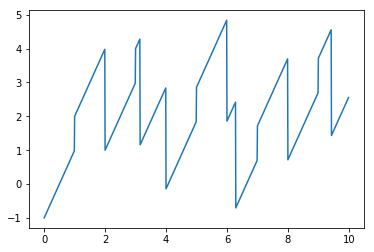

In [3]:
x = np.arange(0,10,0.01)
plt.plot(x, disc_v(x));
plt.show()

In [4]:
Iexact = 5 + (3*np.pi**2 + (10 - 3*np.pi)**2)/2

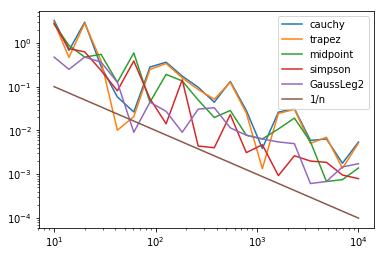

In [5]:
methods = [IM.cauchy, IM.trapez, IM.midpoint, IM.simpson, IM.GaussLeg2]

ns = np.logspace(1,4,20,dtype=int)
for m in methods:
    err = []
    for n in ns:
        I = m(disc_v,0,10, n)
        err.append(abs(I - Iexact))
    plt.loglog(ns, err, label=m.__name__)

plt.loglog(ns, 1/ns, label='1/n')
plt.legend()
plt.show()

## 2) O domínio de integração pode ser "muito feio".

Integrar em 1 dimensão é fácil: basta determinar os extremos dos intervalos.
Mas integrar em mais dimensões é um problema mais chato:
temos regiões de integração que podem ser simples (círculos, quadrados, ...)
ou extremamente complicadas (interior de uma curva, ...).

Como dividir uma região complicada?
O que fazer com os pedacinhos do bordo?

## 3) Interpolar é mais custoso em maior dimensão.

Se queremos achar uma parábola que aproxima uma dada função,
basta tomarmos três pontos, e temos uma aproximação de grau dois.

Se tivermos uma função com 3 variáveis, um polinômio de segundo grau terá 10 coeficientes:
$$ Ax^2 + By^2 + Cz^2 + Dxy + Exz + Fyz + Gx + Hy + Iz + J. $$

Assim, precisamos de 10 pontos para achar este polinômio.
E achar os 10 coeficientes requer resolver um sistema linear $10 \times 10$.
E como escolher os 10 pontos dentro de um cubo?
A forma natural, simétrica, tem 8 vértices... podemos botar um a mais no centro,
e como fazer para o 10º?

## Uma outra idéia: o método de Monte-Carlo

A idéia básica do método de Monte-Carlo é usar pontos aleatórios do domínio de $f$ para calcular a integral.
Podemos ver isso da seguinte forma:

- A média da função é dada pela integral dividida pelo seu domínio:
    $$ \text{média}(f) = \frac{\int_D f}{|D|} $$.
- Mas podemos também calcular esta média de forma amostral:
    $$ \text{média amostral}(f) = \frac{\sum _ {i=1}^N f(x_i)}{N} $$.

A primeira é o que queremos calcular, enquanto que a segunda é fácil de calcular no computador.
A [Lei (Forte) dos Grandes Números][1]
garante que a média amostral converge para a média "de verdade".

Mais ainda, o [Teorema central do limite][2]
mostra que, sob certas hipóteses
(muitas vezes verificadas, mesmo que $f$ seja descontínua!)
o erro de aproximação decresce com a raiz quadrada de $N$:
$$ \text{Amostral}_N(f) - \text{Média}(f) \sim \frac{V}{\sqrt{N}} $$
onde $V$ é a variância de $f$.

[1]: http://pt.wikipedia.org/wiki/Lei_dos_grandes_n%C3%BAmeros
[2]: http://pt.wikipedia.org/wiki/Teorema_central_do_limite

## Brincando: dimensão 1

In [6]:
def mc_int(f,a,b,n):
    r = np.random.rand(n)
    x = a + (b-a)*r
    fs = f(x)
    return (b-a)*sum(fs)/n

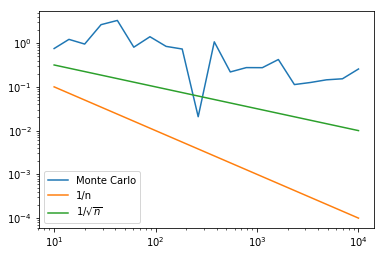

In [7]:
ns = np.logspace(1,4,20,dtype=int)
err = []
Is  = []
for n in ns:
    I = mc_int(disc_v,0,10, n)
    err.append(abs(I - Iexact))
    Is.append(I)
plt.loglog(ns, err, label='Monte Carlo')
plt.loglog(ns, 1/ns, label='1/n')
plt.loglog(ns, 1/np.sqrt(ns), label='$1/\sqrt{n}$')
plt.legend()
plt.show()

Vemos que a convergência realmente parece seguir a velocidade indicada pelo TCL.

Apesar da sua lentidão, o método de Monte Carlo pode também servir para calcular a área $|D|$ da base.

Enfim, o Método de Monte Carlo é o mais simples de ser **continuado**.
Imagine que, após algum tempo, já calculamos o erro com alguma precisão.
Poderíamos continuar calculando
(se o computador não tiver nada melhor para fazer,
por exemplo porque está esperando uma decisão do usuário)
simplesmente sorteando mais pontos.

Assim, usando mais 10000 pontos sobre o último intervalo:

In [8]:
Ibis = mc_int(disc_v,0,10,10000)
Inew = (Ibis + Is[-1])/2
print(Inew - Iexact, 1/np.sqrt(20000))

0.0027721969244396405 0.007071067811865475


Não só isso, podemos também aproveitar pontos de cada um dos cálculos
(pois todos pontos foram aleatórios entre cada rodada):

In [9]:
nsum = sum(ns)
Isum = sum([i*n for n,i in zip(ns,Is)])/nsum
print(Isum - Iexact, 1/np.sqrt(nsum))

-0.04467723862108741 0.005523850307761901


## Indo mais além: o volume da bola

Podemos usar o método de Monte Carlo para calcular o volume da bola unitária.
Para isso, vamos precisar sortear variáveis aleatórias no cubo $C = [-1,1]^n$,
e depois calcular
$$ \int_C f(x)\, dx $$
onde $f(x) = 1$ se $x$ pertence à bola unitária.

(Note que $f$ não é contínua!)

In [10]:
def vetores_no_cubo(dim, num=1):
    """Retorna `num` vetores no cubo [-1,1]^dim."""
    ### Resposta aqui


In [11]:
# 3 vetores em R^4
np.random.seed(123)
vs = vetores_no_cubo(4,num=3)
vs

array([[ 0.39293837, -0.42772133, -0.54629709,  0.10262954],
       [ 0.43893794, -0.15378708,  0.9615284 ,  0.36965948],
       [-0.0381362 , -0.21576496, -0.31364397,  0.45809941]])

In [12]:
def belongs_unit_ball(v):
    """Retorna True se v pertence à bola unitária de R^n, False se não.
    
    A entrada v pode ser uma lista de vetores em R^n; neste caso, retorna um array de bools."""
    assert np.ndim(v) <= 2
    ### Resposta aqui


In [13]:
def unitball(v):
    """Retorna 1 se v pertence à bola unitária de R^n, 0 se não.
    
    A entrada v pode ser uma lista de vetores em R^n; neste caso, retorna um array de 0s e 1s."""
    return 0 + belongs_unit_ball(v)

In [14]:
unitball([1,1,1,1])

0

In [15]:
unitball(vs)

array([1, 0, 1])

In [16]:
def unitball_vol(dim, nsamples=1000):
    """Estima o volume da bola unitária em R^dim, usando `nsamples` amostras no cubo unitário."""
    assert dim < 1e3, "Can't give a precise estimate for such large dimensions"
    ### Resposta aqui


### Safety tests

In [17]:
np.random.seed(4321)

In [18]:
for n in [10, 20, 100, 30000]:
    assert unitball_vol(1, 20) == 2.0

In [19]:
unitball_vol(2) - np.pi

0.038407346410207044

In [20]:
unitball_vol(2,1000000) - np.pi

-0.0008446535897932428

In [21]:
unitball_vol(3) - 4/3*np.pi

-0.1647902047863905

In [22]:
unitball_vol(3,1000000) - 4/3*np.pi

-0.0009662047863905343

### Volume em dimensão qualquer

In [23]:
# from scipy.special import gamma
def factorial(n):
    if n == 0 or n == 1: return 1
    return n * factorial(n-1)
def vol_Bn(dim):
    if dim % 2 == 0:
        return np.pi**(dim/2)/factorial(dim//2) #gamma(dim/2 + 1)

In [24]:
%time unitball_vol(10,1000000)

CPU times: user 199 ms, sys: 32.2 ms, total: 231 ms
Wall time: 231 ms


2.553856

In [25]:
vol_Bn(10)

2.550164039877345

In [26]:
%time unitball_vol(40,1000000)

CPU times: user 564 ms, sys: 136 ms, total: 700 ms
Wall time: 699 ms


0.0

In [27]:
vol_Bn(40)

3.6047307974624982e-09

## Monte Carlo com peso

Também podemos usar variáveis aleatórias $X$ não-uniformes (mas com suporte contendo o domínio de integração),
e daí a estimativa da integral passa a ser:

$$ \int_D f(x) dx \sim \frac{1}{N}\sum_{i=1}^n \frac{f(x_i)}{p(x_i)}$$

onde $p(x)$ é a **densidade de probabilidade** da variável aleatória $X$ em $x$.

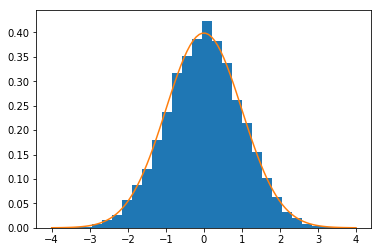

In [28]:
ts = np.linspace(-4,4,num=100)
xs = np.random.randn(10000)
plt.hist(xs, bins=30, density=True)
plt.plot(ts, np.exp(-ts**2/2)/np.sqrt(2*np.pi));

In [29]:
def pdf_normal(v):
    """PDF da normal para o vetor v em R^n.
    
    A entrada v pode ser uma lista de vetores em R^n; neste caso, retorna um array com as respectivas PDF's."""
    assert np.ndim(v) <= 2
    C = 1/np.sqrt(2*np.pi)
    ### Resposta aqui


In [30]:
pdf_normal([1,1,1,1])

0.003428082771526159

In [31]:
vs

array([[ 0.39293837, -0.42772133, -0.54629709,  0.10262954],
       [ 0.43893794, -0.15378708,  0.9615284 ,  0.36965948],
       [-0.0381362 , -0.21576496, -0.31364397,  0.45809941]])

In [32]:
pdf_normal(vs)

array([0.01833554, 0.01337317, 0.02119749])

In [33]:
def unitball_normal_vol(dim, nsamples=1000):
    """Estima o volume da bola unitária em R^dim, usando `nsamples` amostras normais em R^n."""
    ### Resposta aqui


### Novamente, testes de segurança

In [34]:
%time unitball_normal_vol(2, 1000000) - np.pi

CPU times: user 144 ms, sys: 13.9 ms, total: 158 ms
Wall time: 158 ms


0.0013462823380385736

In [35]:
%time unitball_normal_vol(3, 1000000) - 4/3*np.pi

CPU times: user 194 ms, sys: 25.9 ms, total: 220 ms
Wall time: 219 ms


-0.002591450879680046

### E agora, verificando que dá certo!

In [36]:
%time v40 = unitball_normal_vol(40, 1000000)

CPU times: user 1.55 s, sys: 314 ms, total: 1.87 s
Wall time: 1.87 s


In [37]:
vol_Bn(40)

3.6047307974624982e-09

In [38]:
v40/vol_Bn(40) - 1

-0.00154512397961315

In [39]:
%time v200 = unitball_normal_vol(200, 1000000)
v200

CPU times: user 7.16 s, sys: 1.41 s, total: 8.58 s
Wall time: 8.57 s


5.530495818722771e-109

In [40]:
vol_Bn(200)

5.5588328420278045e-109

In [41]:
v200/vol_Bn(200) - 1

-0.005097657028070746